In [ ]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf

# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU details: {gpu}")
else:
    print("No GPU found. Using CPU.")


No GPU found. Using CPU.


In [68]:
IMAGE_SIZE = 256 
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_data = tf.random.uniform((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Data/PotatoDataset",
    shuffle= True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [30]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

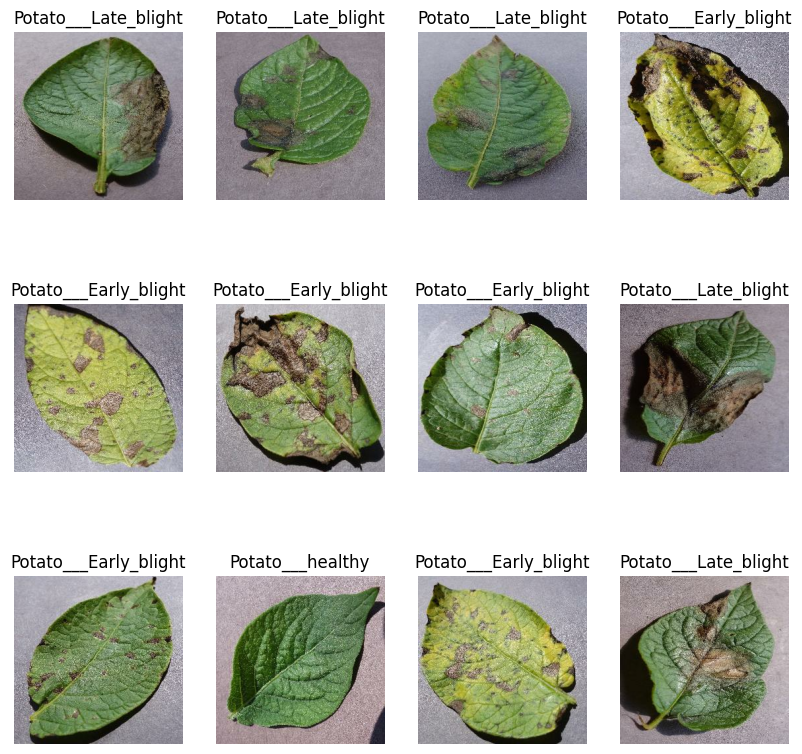

In [31]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Split of Dataset

#### 80 => training

#### 10 => validation

#### 10 => testing

In [33]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [34]:
train_dataset = dataset.take(54)
test_dataset = dataset.skip(54)
validation_dataset = test_dataset.take(6)

In [35]:
test_dataset = test_dataset.skip(6)

In [36]:
len(train_dataset), len(test_dataset), len(validation_dataset)

(54, 8, 6)

In [3]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size = 10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(dataset_size * train_split)
    validation_size = int(dataset_size * val_split)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    
    return train_dataset,validation_dataset,test_dataset

In [39]:
train_dataset,validation_dataset,test_dataset = get_dataset_partitions_tf(dataset)

In [41]:
print(len(train_dataset),len(validation_dataset),len(test_dataset))

54 6 8


In [42]:
# caching
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [72]:
# generally the image numbers are between 255 and 1 so now we must scale it between 0 and 1 
resize_and_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255)
])

In [73]:
# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])


In [74]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)

In [75]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)           │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [77]:
mhistory = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.4041 - loss: 0.9849 - val_accuracy: 0.4792 - val_loss: 0.9047
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 315ms/step - accuracy: 0.4962 - loss: 0.8654 - val_accuracy: 0.7396 - val_loss: 0.6171
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - accuracy: 0.7452 - loss: 0.5878 - val_accuracy: 0.8646 - val_loss: 0.3330
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - accuracy: 0.8380 - loss: 0.3620 - val_accuracy: 0.8646 - val_loss: 0.2833
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 331ms/step - accuracy: 0.8705 - loss: 0.3145 - val_accuracy: 0.8958 - val_loss: 0.2562
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - accuracy: 0.8994 - loss: 0.2314 - val_accuracy: 0.9219 - val_loss: 0.1565
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.9392 - loss: 0.1558 - val_accuracy: 0.9219 - val_loss: 0.1997
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - accuracy: 0.9201 - loss: 0.1802 - val_accu

In [78]:
scores = model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9837 - loss: 0.1154


In [81]:
# [loss,accuracy]
scores

[0.10329580307006836, 0.984375]

In [86]:
mhistory

In [87]:
accuracy = mhistory.history['accuracy']
val_accuracy = mhistory.history['val_accuracy']

loss = mhistory.history['loss']
val_loss = mhistory.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

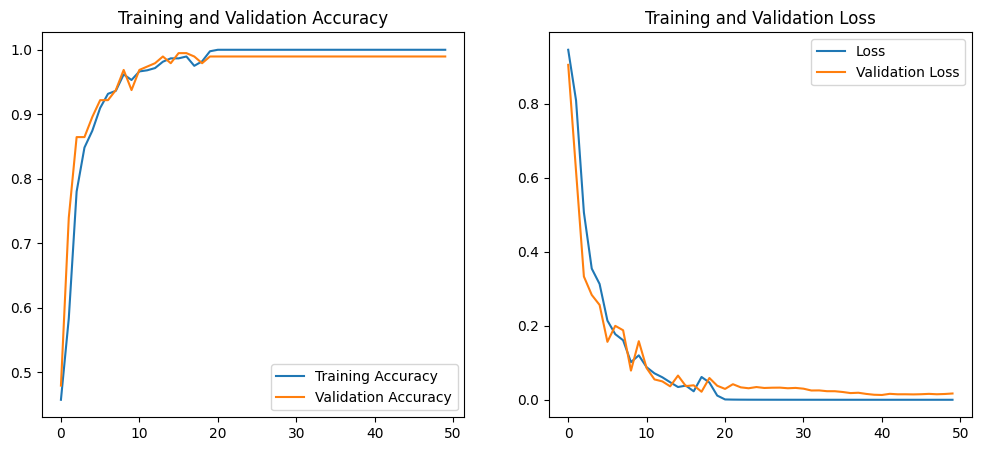

In [95]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label="Validation Accuracy")
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend()
plt.title('Training and Validation Loss')

first image to predict
Actual Image: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Potato___Late_blight


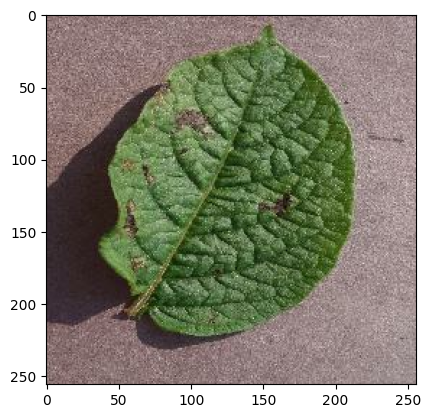

In [101]:
for image_batch,label_batch in test_dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print(f"Actual Image: {class_names[first_label]}")

    batch_predication = model.predict(image_batch)
    print(class_names[np.argmax(batch_predication[0])])

In [105]:
def predict(model,img):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array,0) # This creates a batch

    predictions = model.predict(image_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


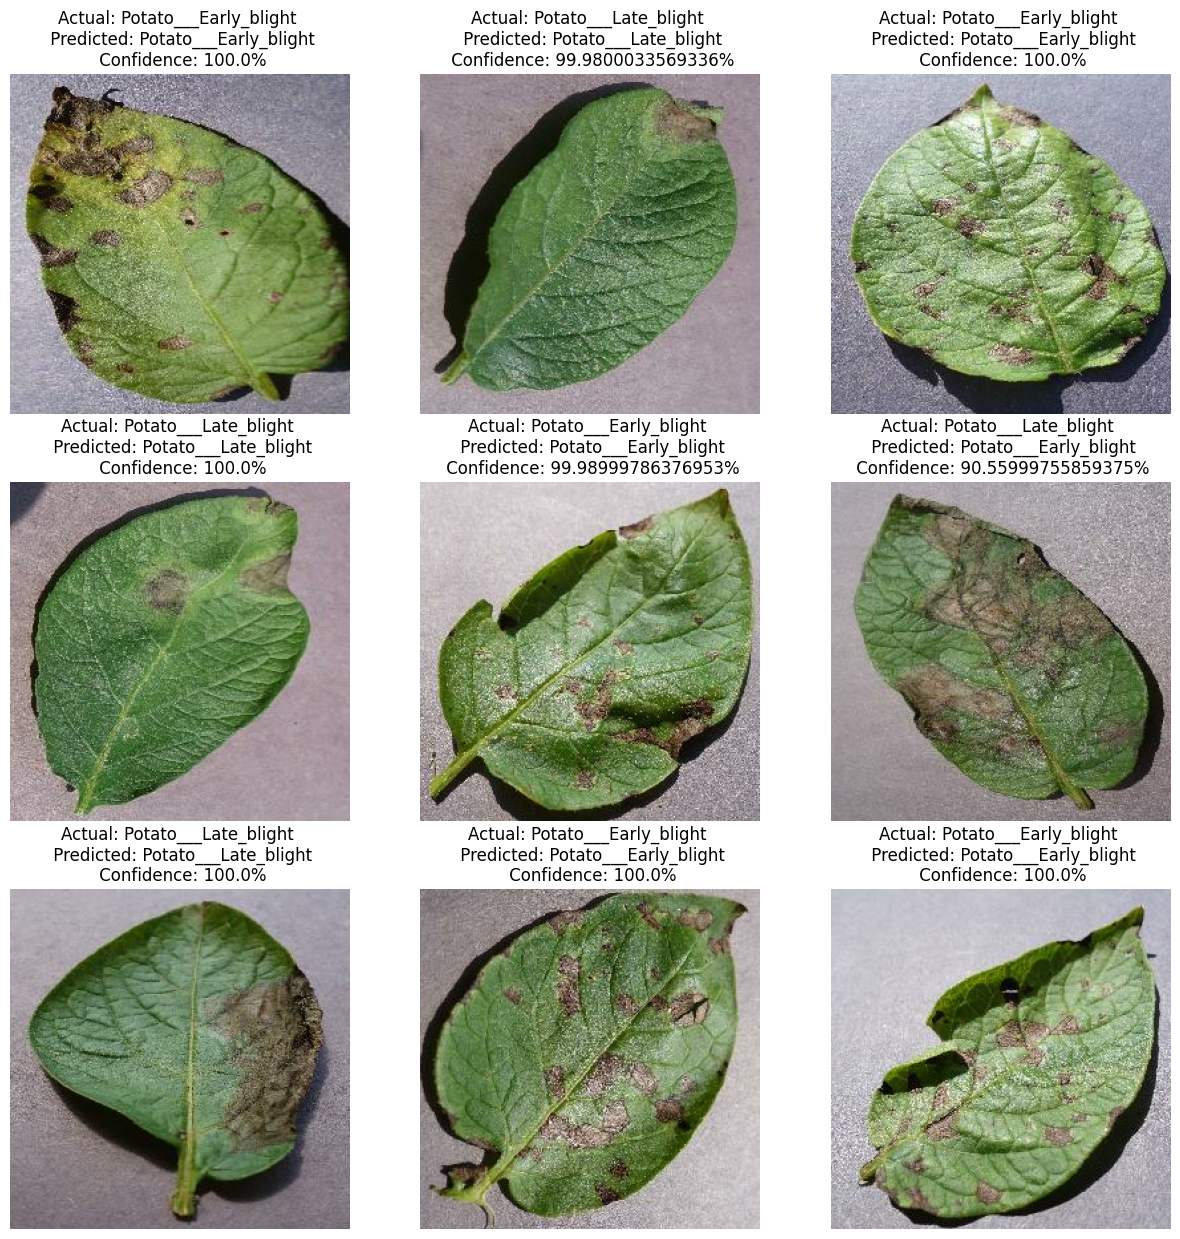

In [109]:
plt.figure(figsize=(15,15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class}\n Confidence: {confidence}%")
        plt.axis("off")
    

In [123]:
[i for i in os.listdir("../models/potato_model")]

['1.keras']

In [124]:
model_dir = "../models/potato_model"
existing_models = os.listdir(model_dir)

# Extract version numbers from the existing model files
existing_versions = [int(model.split('.')[0]) for model in existing_models if model.endswith(".keras")]

# Get the next version number by incrementing the maximum existing version
next_version = max(existing_versions, default=0) + 1

# Save the model with the new version number
model.save(f"{model_dir}/{next_version}.keras")

print(f"Model saved as {next_version}.keras")

Model saved as 2.keras
